<a href="https://colab.research.google.com/github/christiandoramo/Variantes-para-o-epsilon/blob/main/Variantes_do_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tema 2: Variantes para o epsilon <br>
Equipe: <br>
Christian Oliveira <br>
Raphael Barbosa <br>

Info: [tema 2](https://docs.google.com/document/d/1bpqsUML8XkUVBMjiKMLNwbG3npgaF_35xQYrh-Dp4Ts/edit?tab=t.0#heading=h.rs93iuj1gddv )

# Implementação das Variantes do ε

##  Decaimento do ε (Linear e Exponencial)

### Decaimento linear

#### Função

In [ ]:
# testando um tipo de decaimento linear do Epsilon
def linear_decay(initial_E=1.0, min_E=0.005, X=1000):
    # X é o numero do passos (limite) para achar o min_E
    k = (initial_E - min_E)/X
    # k é a taxa de decaimento linear: Epsilon inicial - Epsilon minimo/x
    def new_E(t): # t é o passo atual no treinamento
        return max(min_E, initial_E - k * t)
        # primeira vez -> (0.005, 1 - ((1-0.005)/1000) * 1) (0.005 ou 0,999005)
        # segunda vez -> (0.005, 1 - ((1-0.005)/1000) * 2)...
    return new_E

#### Aplicado ao Q-learning

In [ ]:
# (Q-learning é off-policy) - usando a mesma func E-greedy e apenas alterando o Q-learning do tópico recapitulações
# ajuste dos parametros -> retira epsilon e coloca e_inicial e min, e X

# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # definindo os variaveis dentro de linear_decay de acordo com o q-learning
    epsilon_linear_decay = linear_decay(initial_E,min_E,X)
    t_steps = 0 # contando passos

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            epsilon = epsilon_linear_decay(t_steps) # retorna o novo epsilon com base no linear decay e passo atual

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

            t_steps += 1 # próximo passo

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA

In [ ]:
def run_sarsa_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o SARSA
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Escolhe a próxima ação usando epsilon-greedy
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            next_action = epsilon_greedy(Q, next_state, next_epsilon)

            if terminated:
                # Para estados terminais
                V_next_state = 0
            else:
                # Para estados não-terminais -- valor da próxima ação (SARSA é on-policy)
                V_next_state = Q[next_state, next_action]

            # Atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] = Q[state, action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action  # SARSA usa a próxima ação para a atualização

            t_steps += 1  # Próximo passo

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao Expected-SARSA

In [ ]:
def run_expected_sarsa_linear_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o Expected-SARSA
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Calcula o valor esperado para o próximo estado
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            expected_value = 0  # Inicializa o valor esperado

            # Calcula a probabilidade de cada ação no próximo estado
            for a in range(num_actions):
                if a == np.argmax(Q[next_state, :]):
                    # Probabilidade de escolher a ação gulosa (1 - epsilon + epsilon/num_actions)
                    prob = (1 - next_epsilon) + (next_epsilon / num_actions)
                else:
                    # Probabilidade de escolher uma ação aleatória (epsilon/num_actions)
                    prob = next_epsilon / num_actions
                expected_value += prob * Q[next_state, a]

            if terminated:
                # Para estados terminais
                V_next_state = 0
            else:
                # Para estados não-terminais -- usa o valor esperado
                V_next_state = expected_value

            # Atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] = Q[state, action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = epsilon_greedy(Q, state, next_epsilon)  # Escolhe a próxima ação

            t_steps += 1  # Próximo passo

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA de n Passos

In [ ]:
def run_nstep_sarsa_linear_decay(env, episodes, n=3, lr=0.1, gamma=0.95, initial_E=1, min_E=0.005, X=1000):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # Inicializa a tabela Q toda com zeros
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    # Para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # Definindo as variáveis dentro de linear_decay de acordo com o SARSA de n-passos
    epsilon_linear_decay = linear_decay(initial_E, min_E, X)
    t_steps = 0  # Contando passos

    # Loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # Escolhe a primeira ação usando epsilon-greedy
        epsilon = epsilon_linear_decay(t_steps)
        action = epsilon_greedy(Q, state, epsilon)

        # Listas para armazenar os últimos n estados, ações e recompensas
        states = [state]
        actions = [action]
        rewards = [0]  # A primeira recompensa é 0, pois ainda não houve ação

        # Executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # Realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Escolhe a próxima ação usando epsilon-greedy
            next_epsilon = epsilon_linear_decay(t_steps + 1)
            next_action = epsilon_greedy(Q, next_state, next_epsilon)

            # Armazena o próximo estado, ação e recompensa
            states.append(next_state)
            actions.append(next_action)
            rewards.append(reward)

            # Se já tivermos n passos, atualizamos a Q-table
            if len(states) > n:
                # Calcula o retorno de n-passos
                G = 0
                for j in range(t_steps - n + 1, t_steps + 1):
                    G += (gamma ** (j - (t_steps - n))) * rewards[j]

                # Adiciona o valor do estado final (se não for terminal)
                if not done:
                    G += (gamma ** n) * Q[next_state, next_action]

                # Atualiza a Q-table para o estado e ação de n passos atrás
                update_state = states[t_steps - n]
                update_action = actions[t_steps - n]
                Q[update_state, update_action] += lr * (G - Q[update_state, update_action])

            sum_rewards += reward
            state = next_state
            action = next_action
            t_steps += 1  # Próximo passo

        # Atualiza os últimos n-1 passos que não foram atualizados
        for k in range(max(0, len(states) - n), len(states) - 1):
            G = 0
            for j in range(k, len(states) - 1):
                G += (gamma ** (j - k)) * rewards[j + 1]
            if not done:
                G += (gamma ** (len(states) - 1 - k)) * Q[states[-1], actions[-1]]
            Q[states[k], actions[k]] += lr * (G - Q[states[k], actions[k]])

        all_episode_rewards.append(sum_rewards)

        # A cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

### Decaimento exponencial

#### Função

In [ ]:
import math

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    """
    Função de decaimento exponencial para epsilon.

    Parâmetros:
        initial_E (float): Valor inicial de epsilon (epsilon máximo).
        min_E (float): Valor mínimo de epsilon.
        decay_rate (float): Taxa de decaimento (controla a velocidade do decaimento).

    Retorna:
        Uma função que calcula o epsilon para um dado passo t.
    """
    def new_E(t):
        # Decaimento exponencial suave em direção a min_E
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)

    return new_E

#### Aplicado ao Q-Learning

In [ ]:
import numpy as np
import math
import gym  # Certifique-se de instalar o Gym com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolhe entre as melhores ações

def run_qlearning_exponential_decay(env, episodes, lr=0.1, gamma=0.95,
                                    initial_E=1.0, min_E=0.005, decay_rate=0.001,
                                    verbose=True):
    # Garantindo que o ambiente é discreto
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        t_steps = 0  # Reseta a cada episódio

        while not done:
            epsilon = epsilon_decay(t_steps)
            action = epsilon_greedy(Q, state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Atualização Q-Learning
            V_next_state = 0 if done else np.max(Q[next_state])
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state
            t_steps += 1

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))
        epsilon_values.append(epsilon_decay(t_steps))

        if verbose and (i + 1) % 100 == 0:
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao SARSA

In [ ]:
import numpy as np
import math
import gym  # Certifique-se de instalar o Gym com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores ações

def run_sarsa_exponential_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    # Garantindo que o ambiente é discreto
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Decaimento baseado no episódio
        epsilon_values.append(epsilon)  # Registrar o valor do epsilon

        # Escolhe a primeira ação usando epsilon-greedy
        action = epsilon_greedy(Q, state, epsilon)

        while not done:
            # Executa a ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Escolhe a próxima ação usando epsilon-greedy
            next_action = epsilon_greedy(Q, next_state, epsilon)

            # Atualiza a Q-table (SARSA usa a próxima ação)
            V_next_state = 0 if done else Q[next_state, next_action]
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state
            action = next_action  # Atualiza a ação para o próximo passo

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))  # Média móvel

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao Expected-SARSA

In [ ]:
import numpy as np
import math
import gym  # Certifique-se de instalar com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores ações

def run_expected_sarsa_exponential_decay(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Decaimento baseado no episódio
        epsilon_values.append(epsilon)  # Registrar o valor do epsilon

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_epsilon = epsilon_decay(i + 1)  # Usando episódio como referência

            # Cálculo do valor esperado para o próximo estado
            expected_value = 0
            best_actions = np.where(Q[next_state] == np.max(Q[next_state]))[0]
            prob_best_action = (1 - next_epsilon) + (next_epsilon / num_actions)
            prob_other_actions = next_epsilon / num_actions

            for a in range(num_actions):
                prob = prob_best_action if a in best_actions else prob_other_actions
                expected_value += prob * Q[next_state, a]

            # Atualização da Q-table (Expected SARSA)
            Q[state, action] += lr * (reward + gamma * expected_value - Q[state, action])

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))  # Média móvel

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### Aplicado ao SARSA de N-passos

In [ ]:
import numpy as np
import math
import gym  # Certifique-se de instalar com: pip install gym

def exponential_decay(initial_E=1.0, min_E=0.005, decay_rate=0.001):
    """Função para calcular epsilon com decaimento exponencial."""
    def new_E(t):
        return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)
    return new_E

def epsilon_greedy(Q, state, epsilon):
    """Política epsilon-greedy para escolher ações."""
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))  # Exploração
    else:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]
        return np.random.choice(best_actions)  # Escolhe entre as ações ótimas

def run_nstep_sarsa_exponential_decay(env, episodes, n=3, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.005, decay_rate=0.001, verbose=True):
    """Executa n-step SARSA com decaimento exponencial de epsilon."""

    # Verificações do ambiente
    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))  # Inicializa a Q-table
    all_episode_rewards = []

    epsilon_decay = exponential_decay(initial_E, min_E, decay_rate)  # Função de decaimento de epsilon

    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay(i)  # Epsilon atualizado por episódio

        # Armazena as últimas transições para atualização n-step
        states = [state]
        actions = [epsilon_greedy(Q, state, epsilon)]
        rewards = [0]  # Inicialmente zero

        step_count = 0
        while not done:
            # Executa ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(actions[-1])
            done = terminated or truncated

            sum_rewards += reward
            states.append(next_state)
            rewards.append(reward)

            # Se não for terminal, escolhe a próxima ação
            if not done:
                next_epsilon = epsilon_decay(i)  # Atualiza epsilon com base no episódio
                actions.append(epsilon_greedy(Q, next_state, next_epsilon))
            else:
                actions.append(None)  # No terminal, não há ação

            # Atualiza a Q-table usando o retorno de n-passos
            if step_count >= n - 1:
                G = sum(gamma ** j * rewards[j] for j in range(1, n + 1))  # Soma das recompensas futuras

                if not done and actions[-1] is not None:  # Se não for terminal, adiciona valor esperado
                    G += (gamma ** n) * Q[states[-1], actions[-1]]

                Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

                # Mantém o buffer de tamanho `n`
                del states[0]
                del actions[0]
                del rewards[0]

            step_count += 1

        all_episode_rewards.append(sum_rewards)

        # Atualiza os últimos passos ao final do episódio
        while len(states) > 1:  # Atualiza todas as transições restantes
            G = sum(gamma ** j * rewards[j] for j in range(1, len(states)))
            if actions[-1] is not None:
                G += (gamma ** (len(states) - 1)) * Q[states[-1], actions[-1]]

            Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

            del states[0]
            del actions[0]
            del rewards[0]

        # Exibe progresso a cada 100 episódios
        if verbose and ((i + 1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_reward:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

## Decaimento Adaptativo do ε

### Decaimento baseado no desempenho recente

#### Função

- Se o desempenho médio dos últimos X episódios não piorar, reduzir ε.
- Se o desempenho cair, manter ε estável ou aumentar levemente.

In [ ]:
def adaptive_decay_E(E, recent_rewards, threshold=0.005, decay_factor=0.995, increase_factor=1.005, min_E=0.005, max_E=0.995, X=200):
    if len(recent_rewards) < 2:
        return E  # Não há dados suficientes para avaliar

    N = min(50, len(recent_rewards)//2)  # Número de episódios considerados
    recent_mean = np.mean(recent_rewards[-N:])

    if len(recent_rewards) >= 2*N:
        previous_mean = np.mean(recent_rewards[-2*N:-N])
    else:
        previous_mean = recent_mean  # Evita erro de variável não inicializada

    if recent_mean >= (previous_mean - threshold):  # Melhorou ou manteve
        E = max(E * decay_factor, min_E)
    else:  # Desempenho piorou
        if E < max_E * 0.9:  # Permite aumento apenas se estiver significativamente abaixo do máximo
            E = min(E * increase_factor, max_E)

    return E


#### Aplicado ao Q-learning

In [ ]:


def run_qlearning_adaptive(env, episodes, lr=0.1, gamma=0.95, initial_E=.995, min_E=0.005, threshold=0.005, decay_factor=0.995, increase_factor=1.005, X = 200): # X = numero X de episodios para atualizar
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))  # Inicializa a tabela Q

    all_episode_rewards = []
    recent_rewards = []
    epsilon = initial_E

    for i in range(episodes):
        done = False
        sum_rewards = 0
        state, _ = env.reset()

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            # Atualiza Q-table (Q-Learning)
            V_next_state = 0 if terminated else np.max(Q[next_state])
            Q[state, action] += lr * ((reward + gamma * V_next_state) - Q[state, action])

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)
        recent_rewards.append(sum_rewards)

        if len(recent_rewards) > X:
            recent_rewards.pop(0)

        epsilon = adaptive_decay_E(epsilon, recent_rewards, threshold, decay_factor, increase_factor, min_E,X)

        if (i + 1) % X == 0:
            avg_reward = np.mean(all_episode_rewards[-X:])
            print(f"Episode {i+1} | Avg Reward: {avg_reward:.3f} | Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

#### Aplicado ao SARSA

#### Aplicado ao Expected-SARSA

#### Aplicado ao SARSA de n-passos

### Decaimento proporcional ao desempenho greedy

- Definir um desempenho alvo baseado na melhor política conhecida.
- Ajustar ε proporcionalmente à distância entre o desempenho atual e o desempenho alvo.

Edtratégia:
- Se a recompensa atual estiver abaixo do alvo -> aumenta epsilon (explorar mais)
-Se estiver próximo/acima do alvo -> reduz epsilon (explorar menos)

#### Função

In [ ]:
def adaptive_decay_E_target(E, current_reward,best_avg_reward, decay_factor =0.99, increase_factor=1.01, min_E=.01, max_E-1.00):

  if best_avg_reward is None:
    return E
  performance_ratio = current_reward / best_avg_reward # proporção de proximidade

  if performance_ratio < 1.0:
    E *= increase_factor
  else:
    E *= decay_factor

  return max(min_E, min(E,max_E)) # E nunca passa de máximo ou mínimo

#### Aplicado ao Q-learning

In [ ]:
# Algoritmo Q-learning com decaimento proporcional ao desempenho alvo
def run_qlearning_target(env, episodes, lr=0.1, gamma=0.95, initial_E=1.0, min_E=0.01, max_E=1.0, decay_factor=0.99, increase_factor=1.01):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    Q = np.zeros(shape=(env.observation_space.n, num_actions))  # Inicializa a tabela Q

    all_episode_rewards = []
    epsilon = initial_E
    best_avg_reward = None  # melhor desempenho médio - alvo escolhido na estratégia

    for i in range(episodes):
        done = False
        sum_rewards = 0
        state, _ = env.reset()

        while not done:
            action = epsilon_greedy(Q, state, epsilon) # E-greedy

            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            V_next_state = 0 if terminated else np.max(Q[next_state])
            delta = (reward + gamma * V_next_state) - Q[state, action]
            Q[state, action] += lr * delta

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)

        # pegando a melhor media a cada 100 episódios - melhorar para X episódios
        if (i + 1) % 100 == 0:
            best_avg_reward = np.mean(all_episode_rewards[-100:])

        # trocando E para um baseado no desempenho alvo
        epsilon = adaptive_decay_target(epsilon, sum_rewards, best_avg_reward, decay_factor, increase_factor, min_E, max_E)

        if VERBOSE and ((i + 1) % 100 == 0):
            print(f"Episode {i+1} | Avg Reward (last 100): {best_avg_reward:.3f} | Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q

## Atualizações - ajuste dinâmico

- Manter um histórico das últimas recompensas médias.
- Ajustar ε dependendo da estabilidade do desempenho.

# Testes

Definir melhores ambientes para os decaimentos e parametrização. Criar comparações para o artigo




## Linear Decay

Q-Learning (Epsilon-greedy)

In [ ]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning_linear_decay(env, EPISODES, LR, GAMMA)
clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)

## Adaptive Decay 1

Q-Learning (Epsilon-greedy)

In [ ]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning_adaptive(env, EPISODES, LR, GAMMA)
# clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)

# Experimentos (Frozen, Taxi, Cliff, Racetrack)

## Setup inicial

In [53]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [66]:
import optuna
from functools import partial
import gymnasium as gym
import numpy as np
import math
from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
import matplotlib.pyplot as plt
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

In [54]:
def epsilon_greedy(Q, state, epsilon):
    num_actions = len(Q[state])
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])   # em caso de empates, retorna sempre o menor índice --> mais eficiente, porém...
        #return np.random.choice(np.where(Q[state] == Q[state].max())[0]) # aleatoriza em caso de empates

## Decaimento parametrizado



In [55]:
def epsilon_decay(decay_type='none', initial_E=1.0, min_E=0.005, X=1000, Y=None, total_steps=1000,episodes=8000, decay_rate=0.001):
    """
        decay_type (str): Tipo de decaimento ('linear' ou 'exponential', ou 'none').
        initial_E (float): Valor inicial de epsilon (epsilon máximo).
        min_E (float): Valor mínimo de epsilon.
        X (int): Número de passos para atingir o epsilon mínimo (opcional).
        Y (float): Percentual do tempo total de treinamento para decaimento (opcional).
        total_steps (int): Número total de passos de treinamento.
        decay_rate (float): Taxa de decaimento (apenas para decaimento exponencial).
    """
    if X is None and Y is None:
        raise ValueError("Deve inserir X (número de passos) ou Y (percentual do tempo total).")



    if Y is not None:
        if total_steps is None:
          estimated_steps_per_episode = 500 # sendo usado no env
          total_steps = episodes * estimated_steps_per_episode
        X = int(Y * total_steps)

    if decay_type == 'none':
        def new_E(t):
            return initial_E
    elif decay_type == 'linear':
        k = (initial_E - min_E) / X
        def new_E(t):
            return max(min_E, initial_E - k * t)
    elif decay_type == 'exponential':
        def new_E(t):
            return min_E + (initial_E - min_E) * math.exp(-decay_rate * t)

    else:
        raise ValueError("Tipo de decaimento inválido. Escolha 'linear' ou 'exponential'.")

    return new_E

## Algoritmos TD-learning adaptados

#### Q-learning

In [56]:
def run_qlearning_decay(env, episodes, lr=0.1, gamma=0.95, decay_type='linear', initial_E=1.0, min_E=0.005, X=None, Y=None, total_steps=None, decay_rate=0.001, verbose=True, n_eps_per_rewards=500):
    """
    Parâmetros:
        env: Ambiente Gym.
        episodes (int): Número de episódios de treinamento.
        lr (float): Taxa de aprendizado (learning rate).
        gamma (float): Fator de desconto.
        decay_type (str): Tipo de decaimento ('linear' ou 'exponential').
        initial_E (float): Valor inicial de epsilon.
        min_E (float): Valor mínimo de epsilon.
        X (int): Número de passos para atingir o epsilon mínimo (opcional).
        Y (float): Percentual do tempo total de treinamento para decaimento (opcional).
        total_steps (int): Número total de passos de treinamento (necessário se Y for fornecido).
        decay_rate (float): Taxa de decaimento (apenas para decaimento exponencial).
        verbose (bool): Se True, imprime o progresso durante o treinamento.

    Retorna:
        all_episode_rewards (list): Recompensas de todos os episódios.
        Q (np.array): Tabela Q aprendida.
        avg_rewards (list): Média das recompensas dos últimos 100 episódios.
        epsilon_values (list): Valores de epsilon ao longo do treinamento.
    """
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay_fn = epsilon_decay(decay_type=decay_type, initial_E=initial_E, min_E=min_E, Y=Y, total_steps=total_steps, decay_rate=decay_rate,episodes=episodes)

    eps = 0
    for i in range(episodes):
        eps += 1
        state, _ = env.reset()
        done = False
        sum_rewards = 0


        while not done:
            epsilon = epsilon_decay_fn(eps)
            action = epsilon_greedy(Q, state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Atualização Q-Learning
            V_next_state = 0 if done else np.max(Q[next_state])
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state


        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-n_eps_per_rewards:]))
        epsilon_values.append(epsilon)
        if verbose and (i + 1) % n_eps_per_rewards == 0:
            print(f"Episode {i + 1}: Avg Reward (last {n_eps_per_rewards}): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")
    return all_episode_rewards, Q, avg_rewards, epsilon_values

#### SARSA

In [57]:
def run_sarsa_decay(env, episodes, lr=0.1, gamma=0.95, decay_type='linear', initial_E=1.0, min_E=0.005, X=None, Y=None, total_steps=1000, decay_rate=0.001, verbose=True):
    # Garantindo que o ambiente é discreto
    assert isinstance(env.observation_space, gym.spaces.Discrete), "Apenas espaços discretos são suportados!"
    assert isinstance(env.action_space, gym.spaces.Discrete), "Apenas ações discretas são suportadas!"

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    # Criar a função de decaimento do epsilon
    epsilon_decay_fn = epsilon_decay(decay_type=decay_type, initial_E=initial_E, min_E=min_E, Y=Y, total_steps=total_steps, decay_rate=decay_rate)


    for i in range(episodes):
        state, _ = env.reset()
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay_fn(i)  # Decaimento baseado no episódio
        epsilon_values.append(epsilon)  # Registrar o valor do epsilon

        # Escolhe a primeira ação usando epsilon-greedy
        action = epsilon_greedy(Q, state, epsilon)

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Escolhe a próxima ação usando epsilon-greedy
            next_action = epsilon_greedy(Q, next_state, epsilon)

            # Atualiza a Q-table (SARSA usa a próxima ação)
            V_next_state = 0 if done else Q[next_state, next_action]
            Q[state, action] += lr * (reward + gamma * V_next_state - Q[state, action])

            sum_rewards += reward
            state = next_state
            action = next_action  # Atualiza a ação para o próximo passo

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))  # Média móvel

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values


#### Expected-SARSA

In [58]:
def run_expected_sarsa_decay(env, episodes, lr=0.1, gamma=0.95, decay_type='exponential', initial_E=1.0, min_E=0.005, X=None, Y=None, total_steps=1000, decay_rate=0.001, verbose=True):
    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    epsilon_decay_fn = epsilon_decay(decay_type=decay_type, initial_E=initial_E, min_E=min_E, Y=Y, total_steps=total_steps, decay_rate=decay_rate)


    for i in range(episodes):
        state, _ = env.reset()  # Ajuste para Gym v0.26+
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay_fn(i)
        epsilon_values.append(epsilon)

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_epsilon = epsilon_decay_fn(i + 1)

            expected_value = 0
            best_actions = np.where(Q[next_state] == np.max(Q[next_state]))[0]
            prob_best_action = (1 - next_epsilon) + (next_epsilon / num_actions)
            prob_other_actions = next_epsilon / num_actions

            for a in range(num_actions):
                prob = prob_best_action if a in best_actions else prob_other_actions
                expected_value += prob * Q[next_state, a]

            Q[state, action] += lr * (reward + gamma * expected_value - Q[state, action])

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))

        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values


#### SARSA de n-passos

In [59]:
def run_nstep_sarsa_decay(env, episodes, n=3, lr=0.1, gamma=0.95, decay_type='linear', initial_E=1.0, min_E=0.005,
                     X=None, Y=None, total_steps=1000, decay_rate=0.001, verbose=True):
    """Executa n-step SARSA com decaimento de epsilon."""

    assert isinstance(env.observation_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de estados discreto."
    assert isinstance(env.action_space, gym.spaces.Discrete), "O ambiente deve ter um espaço de ações discreto."

    num_actions = env.action_space.n
    Q = np.zeros((env.observation_space.n, num_actions))  # Inicializa a Q-table
    all_episode_rewards = []
    avg_rewards = []
    epsilon_values = []

    # Criar a função de decaimento do epsilon
    epsilon_decay_fn = epsilon_decay(decay_type=decay_type, initial_E=initial_E, min_E=min_E, Y=Y, total_steps=total_steps, decay_rate=decay_rate)

    for i in range(episodes):
        state, _ = env.reset()
        done = False
        sum_rewards = 0
        epsilon = epsilon_decay_fn(i)  # Epsilon atualizado por episódio
        epsilon_values.append(epsilon)

        # Buffers para armazenar transições
        states = [state]
        actions = [epsilon_greedy(Q, state, epsilon)]
        rewards = [0]  # Inicialmente zero

        step_count = 0
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(actions[-1])
            done = terminated or truncated

            sum_rewards += reward
            states.append(next_state)
            rewards.append(reward)

            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon)
                actions.append(next_action)
            else:
                actions.append(None)

            # Atualiza a Q-table usando o retorno de n-passos
            if step_count >= n - 1:
                G = sum(gamma ** j * rewards[j] for j in range(1, n + 1))  # Soma das recompensas futuras

                if not done:
                    G += (gamma ** n) * Q[states[-1], actions[-1]]

                Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

                # Mantém o buffer de tamanho `n`
                del states[0]
                del actions[0]
                del rewards[0]

            step_count += 1

        all_episode_rewards.append(sum_rewards)
        avg_rewards.append(np.mean(all_episode_rewards[-100:]))

        # Atualiza os últimos passos ao final do episódio
        while len(states) > 1:
            G = sum(gamma ** j * rewards[j] for j in range(1, len(states)))
            if actions[-1] is not None:
                G += (gamma ** (len(states) - 1)) * Q[states[-1], actions[-1]]

            Q[states[0], actions[0]] += lr * (G - Q[states[0], actions[0]])

            del states[0]
            del actions[0]
            del rewards[0]

        # Exibe progresso a cada 100 episódios
        if verbose and ((i + 1) % 100 == 0):
            print(f"Episode {i + 1}: Avg Reward (last 100): {avg_rewards[-1]:.3f}, Epsilon: {epsilon:.4f}")

    return all_episode_rewards, Q, avg_rewards, epsilon_values


## Configuração dos Experimentos

### Hiperparâmetros

In [ ]:
# episodios_de_busca = 8000

# def train_qlearning_decay(ambient, trial: optuna.Trial):
#     eps = trial.suggest_float('initial_E', 1.0, 1.0)
#     Y = trial.suggest_float('Y', 0.00001,0.001)
#     min_eps = trial.suggest_float('min_E', 0.005, 0.2)
#     episodes = trial.suggest_float('episodes', 8000)
#     gamma = trial.suggest_float('gamma', 0.90, 1.00)
#     lr = trial.suggest_float('lr', 0.001, 1.0, log=True)
#     decay_rate = trial.suggest_float('decay_rate', .0001, 0.01, log=True)
#     decay_type = trial.suggest_categorical('decay_type', ['linear', 'exponential','none'])

#     env = gym.make(ambient)
#     returns, _,_,_ = run_qlearning_decay(env, episodios_de_busca, lr=lr, gamma=gamma, decay_type=decay_type,
#                                initial_E=eps, min_E=min_eps, decay_rate=decay_rate,Y=Y)

#     return sum(returns[-100:]) / 100

# def train_sarsa_decay(ambient, trial: optuna.Trial):
#     decay_rate = trial.suggest_float('decay_rate', .0001, 0.01, log=True)

#     eps = trial.suggest_float('initial_E', 1.0, 1.0)  # Epsilon inicial
#     Y = trial.suggest_float('Y', 0.00001,0.001)
#     min_eps = trial.suggest_float('min_E', 0.005, 0.2)
#     gamma = trial.suggest_float('gamma', 0.90, 1.00)  # Fator de desconto
#     lr = trial.suggest_float('lr', 0.001, 1.0, log=True)  # Taxa de aprendizado
#     decay_rate = trial.suggest_float('decay_rate', .0001, 0.01, log=True)
#     decay_type = trial.suggest_categorical('decay_type', ['linear', 'exponential','none'])
#     episodes = trial.suggest_float('episodes', 8000)

#     env = gym.make(ambient)
#     returns, _,_,_ = run_sarsa_decay(env, episodios_de_busca, lr=lr, gamma=gamma, decay_type=decay_type,
#                            initial_E=eps, min_E=min_eps, decay_rate=decay_rate)

#     return sum(returns[-100:]) / 100

# def train_expected_sarsa_decay(ambient, trial: optuna.Trial):
#     Y = trial.suggest_float('Y', 0.0001,0.01)
#     eps = trial.suggest_float('initial_E', 1.0, 1.0)
#     min_eps = trial.suggest_float('min_E', 0.005, 0.2)
#     gamma = trial.suggest_float('gamma', 0.90, 1.00)
#     lr = trial.suggest_float('lr', 0.001, 1.0, log=True)
#     decay_rate = trial.suggest_float('decay_rate', .0001, 0.01, log=True)
#     decay_type = trial.suggest_categorical('decay_type', ['linear', 'exponential','none'])
#     episodes = trial.suggest_float('episodes', 8000)

#     env = gym.make(ambient)
#     returns, _,_,_ = run_expected_sarsa_decay(env, episodios_de_busca, lr=lr, gamma=gamma, decay_type=decay_type,
#                                     initial_E=eps, min_E=min_eps, decay_rate=decay_rate)

#     return sum(returns[-100:]) / 100

# def train_nstep_sarsa_decay(ambient, trial: optuna.Trial):
#     decay_rate = trial.suggest_float('decay_rate', .0001, 0.01, log=True)
#     Y = trial.suggest_float('Y', 0.0001,0.01)
#     eps = trial.suggest_float('initial_E', 1.0, 1.0)
#     min_eps = trial.suggest_float('min_E', 0.005, 0.2)
#     gamma = trial.suggest_float('gamma', 0.90, 1.00)
#     lr = trial.suggest_float('lr', 0.001, 1.0, log=True)
#     decay_type = trial.suggest_categorical('decay_type', ['linear', 'exponential','none'])
#     nsteps = trial.suggest_int('nsteps', 3, 3) # 1-16
#     episodes = trial.suggest_float('episodes', 8000)

#     env = gym.make(ambient)
#     returns, _,_,_ = run_nstep_sarsa_decay(env, episodios_de_busca, n=nsteps, lr=lr, gamma=gamma, decay_type=decay_type,
#                                  initial_E=eps, min_E=min_eps, decay_rate=decay_rate)

#     return sum(returns[-100:]) / 100


#### Buscando para cada ambiente


In [ ]:
# ambientes = ["CliffWalking-v0", "Taxi-v3", "FrozenLake-v1","RaceTrack-v0"]


# best_params = {}
# trials = 1 # 50

# for ambient in ambientes:
#     print(f"\n🔹 Otimizando para ambiente: {ambient}")

#     best_params[ambient] = {}

#     study_qlearning = optuna.create_study(direction='maximize')
#     study_qlearning.optimize(partial(train_qlearning_decay, ambient), n_trials=trials)
#     best_params[ambient]["Q-Learning"] = study_qlearning.best_params
#     print(f"Melhores parâmetros para Q-Learning em {ambient}: {study_qlearning.best_params}")

#     study_sarsa = optuna.create_study(direction='maximize')
#     study_sarsa.optimize(partial(train_sarsa_decay, ambient), n_trials=trials)
#     best_params[ambient]["SARSA"] = study_sarsa.best_params
#     print(f"Melhores parâmetros para SARSA em {ambient}: {study_sarsa.best_params}")

#     study_expected_sarsa = optuna.create_study(direction='maximize')
#     study_expected_sarsa.optimize(partial(train_expected_sarsa_decay, ambient), n_trials=trials)
#     best_params[ambient]["Expected SARSA"] = study_expected_sarsa.best_params
#     print(f"Melhores parâmetros para Expected SARSA em {ambient}: {study_expected_sarsa.best_params}")

#     study_nstep_sarsa = optuna.create_study(direction='maximize')
#     study_nstep_sarsa.optimize(partial(train_nstep_sarsa_decay, ambient), n_trials=trials)
#     best_params[ambient]["n-step SARSA"] = study_nstep_sarsa.best_params
#     print(f"Melhores parâmetros para n-step SARSA em {ambient}: {study_nstep_sarsa.best_params}")

# clear_output()
# print("\n Melhores hiperparâmetros para todos os ambientes e algoritmos:")
# for ambient, algos in best_params.items():
#     print(f"\n🔹 Ambiente: {ambient}")
#     for algo, params in algos.items():
#         print(f"  🔸 {algo}: {params}")

#### Funções de plot

In [91]:
def plot_results(title,rewards_list, labels):
    plt.figure(figsize=(10, 5))
    for rewards, label in zip(rewards_list, labels):
        plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), label=label, linewidth=2)

    plt.xlabel("Episódios")
    plt.ylabel("Recompensa média a cada 10 ep.")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(title)
    plt.show()

### Cliffwalking - Tentando vencer o Epsilon Fixo

##### Q-Learning

In [95]:
# ENV_NAME = "CliffWalking-v0"
# EPISODES = 8000
# LR = 0.01
# GAMMA = 0.95
# EPSILON_NORMAL = .005
# EPSILON_START = 1.0
# EPSILON_MIN = 0.005
# DECAY_LINEAR = .0000000001
# DECAY_EXP = .0001
# Y_LINEAR=.1
# Y_EXP = 0.000001
# X_LINEAR=500
# X_EXP =8000
N_EPS_PER_REWARDS=200

#######
ENV_NAME, r_max = "CliffWalking-v0", 0
EPISODES = 8_000
LR = 0.2
GAMMA = 0.95
EPSILON_NORMAL = 0.1

# Verificar essas var
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005
#######
# Y_LINEAR=.1
# Y_EXP = 0.000001
# X_LINEAR=500
# X_EXP =8000
#######

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR, n_eps_per_rewards=N_EPS_PER_REWARDS)
rewards_exponential, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP,n_eps_per_rewards=N_EPS_PER_REWARDS)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_qlearning_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0,n_eps_per_rewards=N_EPS_PER_REWARDS  # sem decaimento
)
clear_output()

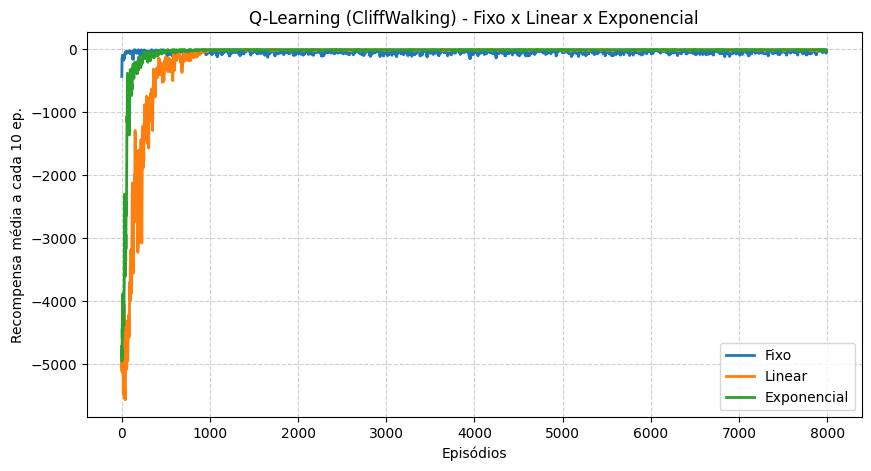

In [98]:
plot_results("Q-Learning (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear,rewards_exponential], ["Fixo","Linear","Exponencial"])
#plot_results("Q-Learning (CliffWalking) - Fixo x Linear",[rewards_no_decay,rewards_linear], ["Fixo","Linear"])

# plot_results("Q-Learning (CliffWalking) - Fixo",[rewards_no_decay], ["Fixo"], 0)

##### Sarsa

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_sarsa_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0  # sem decaimento
)
clear_output()

In [ ]:
plot_results("SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### Expected-SARSA

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Expected-SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### SARSA de n-passos

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Sarsa de n-passos (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

### Cliffwalking

In [ ]:
# plot_results("Linear x Exponencial (Q-Learning) - CliffWalking",[rewards_linear, rewards_exponential], ["Decaimento Linear", "Decaimento Exponencial"], 0)

##### Q-Learning

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_qlearning_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0  # sem decaimento
)
clear_output()

In [ ]:
plot_results("Q-Learning (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### Sarsa

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_sarsa_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0  # sem decaimento
)
clear_output()

In [ ]:
plot_results("SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### Expected-SARSA

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Expected-SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### SARSA de n-passos

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Sarsa de n-passos (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

### Cliffwalking

In [ ]:
# plot_results("Linear x Exponencial (Q-Learning) - CliffWalking",[rewards_linear, rewards_exponential], ["Decaimento Linear", "Decaimento Exponencial"], 0)

##### Q-Learning

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_qlearning_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_qlearning_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0  # sem decaimento
)
clear_output()

In [ ]:
plot_results("Q-Learning (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### Sarsa

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_sarsa_decay(
    env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,
    initial_E=EPSILON_NORMAL, min_E=EPSILON_START,  # epsilon não decai (fixo)
    decay_type="none", decay_rate=0  # sem decaimento
)
clear_output()

In [ ]:
plot_results("SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### Expected-SARSA

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_expected_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Expected-SARSA (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)

##### SARSA de n-passos

In [ ]:
ENV_NAME = "CliffWalking-v0"
EPISODES = 8000
LR = 0.01
GAMMA = 0.95
EPSILON_NORMAL = .005
EPSILON_START = 1.0
EPSILON_MIN = 0.005
DECAY_LINEAR = 0.005
DECAY_EXP = 0.005

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards_linear, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN, decay_type="linear", decay_rate=DECAY_LINEAR)
rewards_exponential, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_START, min_E=EPSILON_MIN,decay_type="exponential", decay_rate=DECAY_EXP)

# # Executa Q-Learning SEM decaimento (epsilon fixo)
rewards_no_decay, _, _, _ = run_nstep_sarsa_decay(env=env, episodes=EPISODES, lr=LR, gamma=GAMMA,initial_E=EPSILON_NORMAL, min_E=EPSILON_START, decay_type="none", decay_rate=0)  # sem decaimento) # epsilon não decai (fixo)
clear_output()

In [ ]:
plot_results("Sarsa de n-passos (CliffWalking) - Fixo x Linear x Exponencial",[rewards_no_decay,rewards_linear, rewards_exponential], ["Fixo","Decaimento Linear", "Decaimento Exponencial"], 0)